# Libraries

In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
from numpy import array

from os import listdir
from os.path import isfile, join
import glob

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cmocean
##from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr

In [2]:
import scipy.linalg as sc
import numpy.linalg as lin

In [3]:
import os
from typing import (
    TYPE_CHECKING,
    Any,
    Callable,
    Dict,
    Hashable,
    Iterable,
    List,
    Mapping,
    Optional,
    Sequence,
    Tuple,
    TypeVar,
    Union,
    cast,
)

# Functions

## Zapata computation

In [4]:
def anomaly(var,option='anom',freq='month'):
    """
    Compute Anomalies according to *option*

    Long description here.

    Parameters
    ----------
    var :   xarray
        array to compute anomalies
    option :
        Option controlling the type of anomaly calculation  
            =============     ==========================================================
            deviation         Subtract the time mean of the time series
            deviation_std     Subtract the time mean and normalize by standard deviation
            anom              Compute anomalies from monthly climatology    
            anomstd           Compute standardized anomalies from monthly climatology
            =============     ==========================================================
    freq :  
        Frequency of data   

    Returns
    -------
    anom :  xarray

    """

    frequency = 'time.' + freq
    if option == 'deviation':
        anom = var - var.mean(dim='time')
    elif option == 'deviation_std':
        anom = (var - var.mean(dim='time'))/var.std(dim='time')
    elif option == 'anom':
        clim = var.groupby(frequency).mean("time")
        anom = var.groupby(frequency) - clim
    elif option == 'anomstd':
        clim = var.groupby(frequency).mean("time")
        climstd = var.groupby(frequency).std("time")
        anom = xr.apply_ufunc(lambda x, m, s: (x - m) / s,
                var.groupby(frequency),
                clim,
                climstd )
    else:
        print(' Wrong option in `anomaly` {}'.format(option))
        raise SystemExit

    return anom

In [5]:
class Xmat():
    """ This class creates xarrays in vector mathematical form.

    The xarray is stacked along `dims` dimensions
    with the spatial values as column vectors and time as the 
    number of columns.

    Specifying the parameter `option` as `DropNaN` will drop all the NaN values
    and the matrix can then be recontructed using the `expand` method.
    

    Parameters
    ----------
    X : xarray
        `xarray` of at leasts two dimensions
    dims : 
        Dimensions to be stacked, *Default ('lat','lon')*
    options :
        Options for Xmat creation
        None :  Keep NaN (Default)
        DropNaN : Drop NaN values

    Attributes
    ----------
    A : xarray
        Stacked matrix of type *xarray*
    _ntime  :
        Length of time points
    _npoints :
        Length of spatial points
    _F : xarray
        Original matrix of type *xarray* with only NaN values 
    
    Examples    
    --------    
    Create a stacked data matrix along the 'lon' 'lat'  dimension

    >>> Z = Xmat(X, dims=('lat','lon'))

    """

    __slots__ = ('A','_F','_ntime','_npoints','_opt')

    def __init__(
        self,
        X,
        dims: Union[Hashable, Sequence[Hashable], None] = None,
        option=None,
        ):

        if not dims:
            SystemError('Xmat needs some dimensions')
            
        self._F = xr.full_like(X,fill_value=np.nan)
        self._opt = option
        self.A = X.stack(z=dims).transpose()
        self._ntime = len(X.time.data)
        self._npoints = len(X.stack(z=dims).z.data)
        print(' Created mathematical matrix A, \n \
                stacked along dimensions {} '.format(dims))
        if self._opt == 'DropNaN':
            self.A = self.A.dropna(dim='z')
            print(' Creating Matrix with Drop NaN values')
           

    def __call__(self, v ):
        ''' Matrix vector evaluation.'''
        f = self.a @ v
        return f

    def __repr__(self):
        '''  Printing Information '''
        print(' \n Math Data Matrix \n {} \n'.format(self.A))
        print(f' Shape of A numpy array {self.A.shape}')
        return  '\n'
    
    def expand(self):
        '''
        Unroll Xmat matrix to xarray

        Examples    
        --------    
        Unroll a stacked and NaN-dropped matrix `X`

        >>> Xlatlon = X.expand()
        '''

        if self._opt == 'DropNaN':
            Aloc =  self.A.unstack()
            self._F.loc[{'lat':Aloc.lat,'lon':Aloc.lon}] = Aloc
            return self._F
        else:
            return self.A.unstack() 
     
    def svd(self, N=10):
        '''Compute SVD of Data Matrix A.
        
        The calculation is done in a way that the modes are equivalent to EOF

        Parameters
        ----------
        N :  
            Number of modes desired.     
            If it is larger than the number of `time` levels    
            then it is set to the maximum

        Returns
        -------
        out : dictionary
            Dictionary including 
                =================     ==================  
                Pattern               EOF patterns    
                Singular_Values       Singular Values 
                Coefficient           Time Coefficients   
                Varex                 Variance Explained  
                =================     ==================
        Examples         
        --------     
        >>> out = Z.svd(N=10) 

        '''
        #Limit to maximum modes to time levels
        Neig = np.min([N,self._ntime])
        print(f'Computing {Neig} Modes')
        # Prepare arrays
        len_modes = self._ntime
        u = self.A.isel(time=range(Neig)).rename({'time': 'Modes'}).assign_coords(Modes= range(Neig))
        u.name = 'Modes'
        
        #Compute modes
        _u,_s,_v=sc.svd(self.A,full_matrices=False)
    
        #EOF Patterns
        u.data = _u[:,0:Neig]
        #Singular values
        s = xr.DataArray(_s[0:Neig], dims='Modes',coords=[np.arange(Neig)])
        #Coefficients
        vcoeff = xr.DataArray(_v[0:Neig,:], dims=['Modes','Time'],coords=[np.arange(Neig),self.A.time.data])
        # Compute variance explained
        _varex = _s**2/sum(_s**2)
        varex = xr.DataArray(_varex[0:Neig], dims='Modes',coords=[np.arange(Neig)])

        #Output
        out = xr.Dataset({'Pattern':u,'Singular_Values': s, 'Coefficient': vcoeff, 'Varex': varex})
        return out

    def corr(self,y, Dim =('time') , option = None):
        """
        Compute correlation of data matrix `A` with index `y`.

        This method compute the correlation of the data matrix
        with an index of the same length of the `time` dimension of `A`

        The p-value returned by `corr` is a two-sided p-value.  For a
        given sample with correlation coefficient r, the p-value is
        the probability that the absolute value of the  correlation of a random sample x' and y' drawn from
        the population with zero correlation would be greater than or equal
        to the computed correlation. The algorithms is taken from scipy.stats.pearsonsr' that can be consulted for full reference

        Parameters
        ----------
        y : xarray  
            Index, should have the same dimension length `time` 

        option : str
            * 'probability' _Returns the probability (p-value) that the correlation is smaller than a random sample
            * 'signicance'  _Returns the significance level ( 1 - p-value)
        
        Returns
        -------
        According to `option`   

        * None  
            corr :  Correlation array  

        * 'Probability'     
            corr :  Correlation array   
            prob :  p-value array  

        * 'Significance'    
            corr :  Correlation array   
            prob :  Significance array  
        
        Examples
        --------
        Correlation of data matrix `Z` with `index`

        >>> corr = Z.corr(index)
        >>> corr,p = Z.corr(index,'Probability')
        >>> corr,s = Z.corr(index,'Significance')
        """
        index= y - y.mean(dim=Dim)
        _corr = (self.A - self.A.mean(dim=Dim)).dot(index)/    \
               (self.A.std(dim=Dim) * y.std(dim=Dim))/self._ntime

        # The p-value can be computed as
        #     p = 2*dist.cdf(-abs(r))
        # where dist is the beta distribution on [-1, 1] with shape parameters
        # a = b = n/2 - 1.  `special.btdtr` is the CDF for the beta distribution
        # on [0, 1].  To use it, we make the transformation  x = (r + 1)/2; the
        # shape parameters do not change.  Then -abs(r) used in `cdf(-abs(r))`
        # becomes x = (-abs(r) + 1)/2 = 0.5*(1 - abs(r)).  

        if option == 'Probability':
            ab = self._ntime/2 - 1
        # Avoid small numerical errors in the correlation
            _p = np.maximum(np.minimum(_corr.data, 1.0), -1.0)
            p = 2*sp.btdtr(ab, ab, 0.5*(1 - abs(_p)))
        
            prob = self.A.isel(time=0).copy()
            prob.data = p
            return _corr , prob
        elif option == 'Significance':
            ab = self._ntime/2 - 1
        # Avoid small numerical errors in the correlation
            _p = np.maximum(np.minimum(_corr.data, 1.0), -1.0)
            p = 2*sp.btdtr(ab, ab, 0.5*(1 - abs(_p)))
        
            prob = self.A.isel(time=0).copy()
            prob.data = 1. - p
            return _corr , prob
        else:
        # return only correlation
            return _corr
    
    def cov(self,y, Dim =('time') ):
        """
        Compute covariance of data matrix `A` with `index`.

        This method compute the correlation of the data matrix
        with an index of the same length of the `time` dimension of `A`

        Examples
        --------
        Covariance of data matrix `Z` with `index`

        >>> cov = Z.cov(index)

        """
        index= (y - y.mean(dim=Dim))
        _cov = (self.A - self.A.mean(dim=Dim)).dot(index)/self._ntime
        return _cov

    def anom(self,**kw):
        """ 
        Creates anomalies.

        This is using the function `anomaly` from `zapata.computation` 
        
        """

        self.A = anomaly(self.A,**kw)
        return

    def detrend(self,**kw):
        '''
        Detrend data using the function scipy.signal.detrend
        '''
        print(f'Detrending data with options -->  {kw}')
        self.A.data = sig.detrend(self.A.data,**kw)
        return


## Zapata Koopman

In [6]:
from scipy.spatial import distance

import klus.algorithms as al
import klus.kernels as kernels
import klus.tools as tools

class Koop():
    """ This class creates the Koopman operator

    The input array is supposed to be in features/samples form
    The augemnted matrix is created inside

    Parameters
    ----------
    vdat: array 
        Data array with features and samples
    
    **kwargs : dict
        * 'operator'          Choice of operator `Koopman` or `Perron` 
        * 'deltat'            Time interval between samples
        * 'kernel_choice'     Kernel choice , `gauss`,`poly`
        * 'sigma'             Bandwidth for Gaussian kernel
            * 'std'   -- Standard Deviation of distances
            * 'median -- Median of distances
            * '100'   -- Explicit value
        * 'epsilon'             Regularization parameter 
        * 'maxeig'     Max number of eigenvalues to compute
        * 'poly_order': 1     Order of polynomial kernel
        * 'poly_shift':0      Shift of polynomial kernel 

    Attributes
    ----------
    PsiX : numpy array
        Reduced data matrix of type *array*
    PsiY : numpy array
        Shifted data matrix of type *array*
    ntime  : int
        Number of samples or time points
    npoints : int
        Number of features or spatial points
    deltat : float
        Time interval between samples
    operator: str
        Operator chosen {'Koopman', 'Perron'}
    kernel_choice: object
        Kernel used in the estimator
    epsilon : float
        Tikhonov Regularization parameter {1e-5}
    sigma : float
        Bandwidth for Gaussian kernel
    maxeig : int
        Maximum number of eigenvalues to compute
    poly_order: int
        Order polynomial kernel
    poly_shift: float
        Shift polynomial kernel
    ww: array
        Koopman eigenvalues
    wwg: array
        Koopman generator eigenvalues
    cc: array
        Koopman eigenfunctions coefficients
    vv: array
        Koopman eigenfunction values on the samples
    wf: array
        Filtered Koopman eigenvalues
    wfg: array
        Filtered Koopman generator eigenvalues
    vvf: array
        Filtered Koopman eigenfunction values on the samples
    Gxx: array
        Kernel Matrix Gxx
    Gxy: array
        Kernel Matrix Gxy
    ker: object
        Object Kernel used
    time_data:
        Time array (optional)

    Examples    
    --------    
    Create a Koopman operator 

    >>> K = Koop(X, {operator: 'koopman', 
            kernel_choice : 'gauss', sigma : 42, epsilon : 1e-5})

    """

    __slots__ = ('PsiX','PsiY','ntime','npoints', 'operator', 'deltat','time_data',\
                'kernel_choice','epsilon','sigma','maxeig','bandwidth',\
                'poly_order','poly_shift', 'k_shift',\
                'wf','wfg','vvf',\
                'ww','wwg','vv','cc','Gxx','Gxy','ker')
    

    def __init__(
        self,
        vdat,
        **kwargs ):
        
        #Set default arguments
        defaultOptions = {'operator': 'Koopman', 'deltat':1,
            'kernel_choice' : 'gauss', 'bandwidth' : 'std', 'epsilon' : 1e-5, 'maxeig':3000,
            'poly_order': 1,'poly_shift':0,'k_shift':0.0, 'time_data': None}
        options ={**defaultOptions, **kwargs}
        
        self.PsiX = vdat[:,:-1]
        '''Reduced Data matrix of type (`array`)'''
        self.PsiY = vdat[:,1:]
        '''Shifted data matrix of type (`array`)'''
        self.ntime = self.PsiX.shape[1]
        '''Number of samples or time points (`int`)'''
        self.npoints = self.PsiX.shape[0]
        '''Number of features or spatial points (`int`)'''
        self.deltat = 1
        '''Time interval between samples (`float`)'''
        
        self.bandwidth = None
        '''Option Bandwidth for Gaussian kernel (`str`)'''
        self.sigma = None
        '''Bandwidth for Gaussian kernel (`float`)'''
        self.operator = options['operator']
        '''Operator chosen (`str`) {'Koopman', 'Perron'}'''
        self.kernel_choice = options['kernel_choice']
        '''Kernel used in the estimator (`str`)'''
        self.epsilon = options['epsilon']
        '''Tikhonov Regularization parameter (`float`) {1e-5}'''
        self.maxeig = options['maxeig']
        '''Maximum number of eigenvalues to compute (`int`)'''
        self.poly_order = options['poly_order']
        '''Order polynomial kernel (`int`)'''
        self.poly_shift = options['poly_shift']
        '''Shift polynomial kernel (`float`)'''
        self.k_shift = options['k_shift']
        '''Shift  kernel (`float`)'''
        if options['time_data'] is not None:
            self.time_data = options['time_data']
        else:
            self.time_data = np.arange(self.ntime)
        '''Time array (`array`)'''

        print(f'Created {self.operator} Estimator \n for {self.ntime} samples and {self.npoints} features, \
            {self.deltat} time interval' )

        self.wf = None
        '''Filtered Koopman eigenvalues (`array`)'''
        self.wfg = None
        '''Filtered Koopman generator eigenvalues (`array`)'''
        self.vvf = None
        '''Filtered Koopman eigenfunction values on the samples (`array`)'''

        self.ww = None
        '''Koopman eigenvalues (`array`)'''
        self.wwg = None
        '''Koopman generator eigenvalues (`array`)'''
        self.vv = None
        '''Koopman eigenfunction values on the samples (`array`)'''
        self.cc = None
        '''Koopman eigenfunctions coefficients (`array`)'''
        self.Gxx = None
        '''Kernel Matrix Gxx (`array`)'''
        self.Gxy = None
        '''Kernel Matrix Gxy (`array`)'''
        self.ker = None
        '''Kernel used (`object`)'''

    def __call__(self, v ):
        ''' Not implemented'''
        print('Not implemented')
        return 

    def __repr__(self):
        '''  Printing Information '''
        print(f'Koopman Estimator for operator {self.operator} with paramenters:\n \
                Kernel_choice {self.kernel_choice}\n \
                Maxeig {self.maxeig}\n \
                Epsilon {self.epsilon}  \n ')
        if self.kernel_choice == 'poly':
            print(f' Poly_Order {self.poly_order} \n \
                     Poly_Shift {self.poly_shift}\n ')
        elif self.kernel_choice == 'gauss':
            print(f'  Bandwidth {self.sigma}\n \
                      ')
        return '\n'

    
    def fit(self,bandwidth=None, condition= 1e-15):               #taken from zapata vecchio
        ''' 
        Fitting estimator.
        Select bandwidth with `bandwidth`

        Parameters
        ----------
        bandwidth: string
            Select the bandiwidth for the Gaussian kernel
                * 'std'             Use bandwidth that make the distances of std 1
                * 'median'          Use median value of distances
                * '100'             Use this explicit numerical value    
                
        Returns
        -------  
        ww:
            Eigenvalues
        self.wwg = np.log(ww_tot)/self.deltat:
            Generator Eigenvalues
        self.vv:
            Value of Eigenfunctions at samples
        self.Gxx:
            kernel matrix Gxx
        self.Gxy:
            kernel matrix Gxy
        self.ker:
            Kernel used

        '''
        condition = condition            #changed, 1e-15 for newer paper,     1e-5 older navarra paper

        
        if self.operator == 'Perron': 
            ops='P'
        elif self.operator =='Koopman':
            ops='K'
        else:
            raise ValueError('TRANSFER_OP_GAUSS:  --- Wrong Operator choice ')
        print(' Calculating {} Operator '.format(self.operator))

        self.bandwidth = bandwidth

        if bandwidth is None or bandwidth == 'std':
            similarity=distance.squareform(distance.pdist(self.PsiX.T ,'sqeuclidean'))
            scale=np.std(similarity.flatten())
        elif bandwidth == 'median':
            similarity=distance.squareform(distance.pdist(self.PsiX.T ,'sqeuclidean'))
            scale = np.median(similarity.flatten())
        else:
            scale = 2*(float(bandwidth))**2
       
        self.sigma = np.sqrt(scale/2)
        print(f'Using option {bandwidth} for a  {scale} and sigma {self.sigma}\n')

        if self.kernel_choice == 'gauss':
            k = kernels.gaussianKernel(self.sigma)
        elif self.kernel_choice == 'poly':
            k = kernels.polynomialKernel(p=self.poly_order,c=self.poly_shift)
        elif self.kernel_choice == 'gaussShifted':
            k = kernels.gaussianKernelShifted(self.sigma, shift=self.k_shift)
        else:
            raise ValueError(f'KK_fit:  --- WrongKernel choice {self.kernel_choice}')
        
        ww_tot,vv_tot,cc_eig,A,Gxx,Gxy =al.kedmd(self.PsiX,self.PsiY, k, \
                epsilon=self.epsilon, evs=self.maxeig, operator=ops,kind='kernel',cond=condition)
        
        print(f'Computed Transfer Eigenvalues')
        self.ww = ww_tot
        self.wwg = np.log(ww_tot)/self.deltat
        self.vv = vv_tot
        self.cc = cc_eig
        self.Gxx = Gxx
        self.Gxy = Gxy
        self.ker = k

        return 
    
    def order(self,choice='frequency',direction='down',cut_period=3):
        ''' 
        Order Eigenvalues according to `option`

        Parameters
        ----------
        option:
            * 'magnitude'         abs(w)
            * 'frequency'         w.imag
            * 'growth'            log(w).real/dt
            * 'ones'              abs(w) closest to 1.0
            * 'stable'            log(w).real/dt irrespextive of sign 
        
        direction:
            * 'up'               descending
            * 'down'             ascending
        
        cut_period:
            Eliminate modes with shorter periods (sample units)
        
        Returns
        -------

        wf:
            Ordered Koopman Eigenvalues
        wfg:
            Ordered generator eigenvalues
        vvf:
            Ordered Koopman eigenfunctions
            
        '''

        #  cut period in (months)

        if cut_period is not 0:
            wmax = np.max(np.where(2*math.pi/self.wwg.imag > cut_period))
        else:
            wmax = len(self.wwg.imag)

        _wf =self.ww[0:wmax]
        _vvf = self.vv[:,0:wmax]
        print(f'Eliminating frequency higher than {cut_period} months, \
            original modes {len(self.ww)}, remaining {len(_wf)}')
        
        wf,wfg, indf = order_w(_wf,option=choice,direction=direction,tdelta=self.deltat)

        self.wf = wf
        self.wfg = wfg
        self.vvf = _vvf[:,indf]

        return wf, wfg, self.vvf
    
    def eigone(self,ww,vv,tol=0.1,select='one',verbose=True):
    
        '''  
        Choose stable eigenvalues, either according their absolute value
        or according the sign of the real part

        Parameters
        ----------

        ww: complex
            Koopman Eigenvalues
        vv: array complex
            Koopman eigenfunctions
        select:
            * `one`       Eigenvalues close to one in Abs less than `tol`
            * `stable`    Real part < 0
            * `unstable`  Real part > 0
        tol:
            Tolerance
        verbose:
            Print Diagnostics
        

        Returns
        -------

        ww:
            Selected eigenvalues
        vv:
            Selected eigenfunctions
        ind:
            Index of selected eigenvalues
        '''
        
        print(f'Keeping only EI close to unity less than tol {tol}')

        indone = choose_eig(select,ww,tol,self.deltat)
        N1 = len(indone)
        wone = ww[indone]
        print(f'\n Trace of generator eigenvalues close to unity according to tolerance {tol} --->  {sum(np.log(wone))}')
        print(f' Factor of Phase Volume contraction {np.exp(sum(np.log(wone))):.6f} per month\n')
        # Order retained unitary eigenvalues and obtain generator eigenvalues 'expwr'
        print(f'Number of Eigenvalues found {N1} over {len(ww)} for kmode tol {tol}\n\n')
        # _,expwr,indexpwr = order_w(wone,option='stable',direction='down',tdelta=1)

        headr = ('Mode','Real Eig','Im Eig','Abs','Gen Real (Yr)','Gen Imag (Yr)')
        kaz_data = [(i,wone[i].real, wone[i].imag, abs(wone[i]), 1./np.log(wone[i]).real/12,   2*math.pi/np.log(wone[i]).imag/12) for i in range(min(len(wone),50))]
        if verbose:
            print(tab.tabulate(kaz_data, headr,stralign='center',tablefmt='github'))
        _vv = vv[:,indone]

        return wone,_vv,indone

    def compute_modes(self,ww,vv,modetype='',description='',normalization=False):
        '''
        Compute Koopman Modes
        
        Parameters
        ----------
        
        ww:
            Koopman eigenvalues
        vv:
            Value of Koopman EIgenfunctions at samples
        modetype:
            Descriptive label 
        description:
            Data Descritpion
        normalization:
            If `False` (Default) the eigenfunctions are not normalized, se to`True`
            to get Koopman modes over normalized eigenfunctions.
        
        
        Returns
        -------
        
        ds : data set
            .. table:: Content for `ds`
               :widths: auto

               ======================        ============================================
               Variable                      Description
               ======================        ============================================
               keig(time,modes)              Normalized Koopman eignfunction values at sample points
               kmodes(features,modes)        Koopman modes
               periods                       Periods of Koopman modes
               eigenvalues                   Koopman Eigenvalues
               ======================        ============================================
        '''
        
        Nmodes = vv.shape[1]
        Ntimes = self.ntime 
        Nfeatures = self.npoints

        # Normalize Koopman eigenfunctions
        if normalization:
            vvnorm = sc.norm(vv,axis=0)
            vnormalized = vv@np.diag(1./vvnorm)
        else:
            vnormalized = vv

        # The ordering is consistent with Mezic
        Phiinv, vrank = sc.pinv(vnormalized,return_rank=True)
        KMM = Phiinv@(self.PsiX.T)
        print(f'Computed Kmodes {KMM.shape} for {vv.shape} normalized eigenfunctions')
        print(f'Computed Kmodes {Nmodes} {Nfeatures} vv  {Ntimes} {Nmodes} eigenfunctions')
        print(f'Rank of V matrix {vrank}')
        

        # Create Data Sets for Koopman modes
        ds = xr.Dataset(
            data_vars=dict(
            kmodes=(["x", "modes"], KMM.T),
            eigfun=(["time", "modes"], vnormalized),
            periods=(["modes"],  2*math.pi/np.log(ww).imag/12),
            eigval=(["modes"],  ww )                                 ),

        coords=dict(
            feature=(["x"], np.arange(Nfeatures)),
            time=(["time"], self.time_data),
            modes=(["modes"], np.arange(Nmodes) ) ),
        attrs=dict(type=modetype, description=description)  )

        return ds
    
    def compute_modes_y(self,ww,vv,modetype='',description='',normalization=False):
        '''
        Compute Koopman Modes
        
        Parameters
        ----------
        
        ww:
            Koopman eigenvalues
        vv:
            Value of Koopman EIgenfunctions at samples
        modetype:
            Descriptive label 
        description:
            Data Descritpion
        normalization:
            If `False` (Default) the eigenfunctions are not normalized, se to`True`
            to get Koopman modes over normalized eigenfunctions.
        
        
        Returns
        -------
        
        ds : data set
            .. table:: Content for `ds`
               :widths: auto

               ======================        ============================================
               Variable                      Description
               ======================        ============================================
               keig(time,modes)              Normalized Koopman eignfunction values at sample points
               kmodes(features,modes)        Koopman modes
               periods                       Periods of Koopman modes
               eigenvalues                   Koopman Eigenvalues
               ======================        ============================================
        '''
        
        Nmodes = vv.shape[1]
        Ntimes = self.ntime 
        Nfeatures = self.npoints

        # Normalize Koopman eigenfunctions
        if normalization:
            vvnorm = sc.norm(vv,axis=0)
            vnormalized = vv@np.diag(1./vvnorm)
        else:
            vnormalized = vv

        # The ordering is consistent with Mezic
        Phiinv, vrank = sc.pinv(vnormalized,return_rank=True)
        KMM = Phiinv@(self.PsiY.T)
        print(f'Computed Kmodes {KMM.shape} for {vv.shape} normalized eigenfunctions')
        print(f'Computed Kmodes {Nmodes} {Nfeatures} vv  {Ntimes} {Nmodes} eigenfunctions')
        print(f'Rank of V matrix {vrank}')
        

        # Create Data Sets for Koopman modes
        ds = xr.Dataset(
            data_vars=dict(
            kmodes=(["x", "modes"], KMM.T),
            eigfun=(["time", "modes"], vnormalized),
            periods=(["modes"],  2*math.pi/np.log(ww).imag/12),
            eigval=(["modes"],  ww )                                 ),

        coords=dict(
            feature=(["x"], np.arange(Nfeatures)),
            time=(["time"], self.time_data),
            modes=(["modes"], np.arange(Nmodes) ) ),
        attrs=dict(type=modetype, description=description)  )

        return ds

    def reconstruct_koopman(self,ds,decode=None,select_modes=None):
        '''
    
        Reconstruction of data from Koopman modes
        
        Parameters
        ----------
       
        ds:
            Koopman decomposition from `compute_modes`
        
        decode:
            Array decoding features
            
        decode: 
            If not empty contains the array for decoding
            to physical space
        
        select_modes: list
            If not empty reconstrut using only selected modes
            [2,7,4]
            

            
        Returns
        -------
        
        data : Array
            Reconstructed data
            
        '''

        if select_modes is None:
            y = ds.eigfun@ds.kmodes
        else:
            y = ds.eigfun.isel(modes=select_modes)@ds.kmodes.isel(modes=select_modes)

        #Check Reality
        if np.sum(y.imag**2) > 1.e-14:
             raise ValueError(f'reconstruct_koopman:  --- Array not Real {np.sum(y.imag**2)}')
        else:
            y = y.real

        if decode is None:
            return y
        else:
            return decode@y.data.T
    def find_norm_modes(self,KM, KE, KEI, sort='sort',decode=None,simplify_conjugates=True):
        '''
        Compute norms of eigenfunctions 
        eliminate complex conjugates, optionally sort in order
        of magnitude  

        Parameters
        ----------
        KM:
            Koopman Modes (KM)
        KE: 
            Koopman Eigenfunctions (KE)
        KEI:
            Koopman EIgenvalues (KEI)
        sort:
            'sort' -- get also sorted eigenvector in order of magnitude
        decode:
            None -- No decoding is applied, otherwise use array `decode`
        simplify_conjugates:
            If `True` only modes with imaginary part >= 0 are retained

        Returns
        -------

        (vnorm, KM, VM, KEI):
            Koopman Modes Norms, Koopman Modes, Eigenfunctions, Eigenvalues
        (vnormsort, KM_sort, VM_sort, KEI_sort):
            Sorted Koopman Modes Norms, Koopman Modes, Eigenfunctions, Eigenvalues
        '''

        # Eliminate complex conjugates
        if simplify_conjugates:
            print(f'\n `find_norm_modes` Retain only positive frequencies or zero \n')
            ivar = np.where(KEI.imag >= 0)
            KM_single = KM[:,ivar[0]]
            VM_single = KE[:,ivar[0]]
            wti = KEI[ivar[0]]
        else:
            KM_single = KM[:,:]
            VM_single = KE[:,:]
            wti = KEI[:]

        if decode is None:
            KM_out = KM_single.data
        else:
            KM_out =  decode@KM_single.data

        vvar = np.diag(KM_single.T.conj().data@KM_single.data).real
        vnorm = np.sqrt(vvar)

        if sort == 'sort':
            # Sort in order of magnitude
            indnorm = np.argsort(vnorm)[::-1]
            return (vnorm,KM_out, VM_single, wti), (indnorm, vnorm[indnorm],KM_out[:,indnorm], VM_single[:,indnorm], wti[indnorm])
        else:
            return (vnorm,KM_out, VM_single, wti)
    def eigenfunction_value( self, x, mode ):
        '''
        Compute eigenfunction value at point x
        
        Parameters
        ----------
        
        x:
            Point at which eigenfunction is computed
        mode:
            Eigenfunction number
        
        Returns
        -------
        
        eigenfunction value
        '''
        k = self.ker
        f = 0
        for i in range(self.ntime):
            f +=  self.cc[i,mode]*k(x, self.PsiX[:, i])
        return f


# Code

## Subset data

In [7]:
#Aneesh
#ds = xr.open_dataset('/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/historical/r10i1p1f1/6hrLev/ua/gn/latest/ua_6hrLev_CESM2_historical_r10i1p1f1_gn_198001010000-198912311800.nc')

#Mine
#ds1 = xr.open_dataset('/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Omon/tos/gr/latest/tos_Omon_CESM2_piControl_r1i1p1f1_gr_000101-009912.nc')

In [8]:
ds = xr.open_mfdataset(

    "/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Omon/tos/gr/latest/tos_Omon_CESM2_piControl_r1i1p1f1_gr_*.nc", concat_dim="time")  

/ncar/usr/jupyterhub/envs/cmip6-201910/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


In [9]:
ds

<xarray.Dataset>
Dimensions:    (time: 14400, d2: 2, lat: 180, lon: 360)
Coordinates:
  * time       (time) object 0001-01-15 13:00:00 ... 1200-12-15 12:00:00
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Dimensions without coordinates: d2
Data variables:
    time_bnds  (time, d2) object dask.array<chunksize=(1188, 2), meta=np.ndarray>
    lat_bnds   (time, lat, d2) float64 dask.array<chunksize=(1188, 180, 2), meta=np.ndarray>
    lon_bnds   (time, lon, d2) float64 dask.array<chunksize=(1188, 360, 2), meta=np.ndarray>
    tos        (time, lat, lon) float32 dask.array<chunksize=(1188, 180, 360), meta=np.ndarray>
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    case_id:                3
    cesm_casename:          b.e21.B1850.f09_g17.CMIP6-piControl.001
    contact:                cesm_cmip6@ucar.edu
    creation_date:          2019-01-20T19:48:15Z
    ...                     ...
    variable_id:            tos
    variant_info:           CMIP6 CESM2 piControl experiment with CAM6, inter...
    variant_label:          r1i1p1f1
    branch_time_in_parent:  48545.0
    branch_time_in_child:   0.0
    branch_method:          standard

In [10]:
ds=ds.isel(d2=0)

In [11]:
#  Read Variable
area='NAVARRA_2021'
if area == 'TROPIC':
    # central pacific coordinates
    arealat=(35,-35)
    arealon=[-180, 180.]
elif area == 'GLOBAL':
    arealat=(60,-60)
    arealon=[-160,110.]
elif area == 'WORLD':
    arealat=(60,-60)
    arealon=[-180,180.]
elif area == 'NAVARRA_2021':
    arealat=(-15,15)
    arealon=[140,290.]
else:
    Print(f'No area ')
    
case = 'UNIT'    
data_name= 'ERA5' + area
variable='SST'
lev = 'SURF'
shift = 'ERA5'
period = 'ANN'
normalization = 'anom'

# Use SVD encoding
encode_svd = True
#Choose number of SVD to ratain
var_retained = None #None# Variance retained or None for full rank
#Option to write files
write_files = False

In [12]:
S = ds.sel(lat=slice(arealat[0],arealat[1]),lon=slice(arealon[0],arealon[1]))
#S.data[abs(S.data) > 100] = np.nan


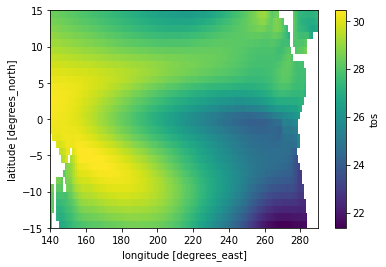

In [13]:
S.mean(dim='time').tos.plot()

## Define anomaly

In [14]:
#Anomalies
S = anomaly(S.tos.compute() ,option='anomstd',freq='month') 

In [15]:
X=Xmat(S,dims=('lat','lon'))
X.A = X.A.dropna(dim='z')

 Created mathematical matrix A, 
                 stacked along dimensions ('lat', 'lon') 


## Compute EOFs

In [16]:
xdat = X.A.data
if encode_svd:
    udatx, sdatx, vhdatx = sc.svd(xdat[:,:], full_matrices=False)
    
    if not var_retained:
        mr=lin.matrix_rank(xdat)
        print(f'  Number of SVD modes set to Rank {mr}')
    else:
        mr = np.min(np.where(np.cumsum(sdatx**2/sum(sdatx**2)) > var_retained -0.001))
        print(f'  Number of SVD modes retained {mr}')
    var = sdatx**2
    print(f'Variance Retained {sum(sdatx[0:mr]**2)/sum(var):.4f}')


  Number of SVD modes set to Rank 650
Variance Retained 0.9997


In [17]:
mr = 360     #31
var = sdatx**2
print(sum(sdatx[0:mr]**2)/sum(var))

0.9986086945930772


Standardize Coefficients and Reduce dimensionality via an EOF encoding

(4203, 360) (360,) (360, 14400)

  Singular values of the data 
 [5375.3843   2677.642    2097.0476   1758.7953   1612.9906   1255.1709
 1142.2554   1074.1605   1004.5862    875.9416    836.0072    755.51074
  747.8311    654.43115   633.9908    606.2078    576.6654    534.5058
  501.1815    480.75742   464.48312   440.92722   421.84302   400.5867
  392.6492    387.03235   366.64633   344.7678    339.91818   332.75256
  309.73804   301.55615   300.72546   288.81497   281.74823   277.41513
  269.12064   257.67084   252.13393   245.29735   241.05843   239.59666
  224.81653   221.31998   220.26201   215.7907    209.89221   203.1499
  201.50377   198.64595   197.05641   191.65639   186.5907    181.86707
  179.15425   177.30052   175.05746   173.4328    171.37828   168.13202
  165.3568    159.2128    157.6626    154.58687   152.18782   148.69286
  147.55165   145.51274   143.79773   138.20773   136.25157   135.5904
  132.5103    130.65607   129.88902   128.96692   127.2821    125.28783
  12

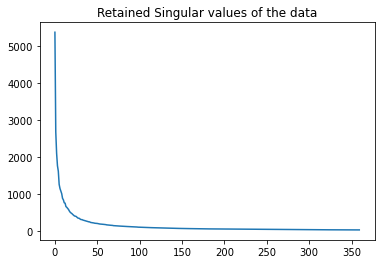

In [18]:
#keep only mr modes
udat_tot=udatx[:,0:mr]
sdat=sdatx[0:mr]
# the columns of vhdatx contain the coefficients of the field (standardized to unit variance)
vhdat=vhdatx[0:mr,:]
# coffieints non standardized directly from projection on EOF
vdat_tot=udat_tot.T.conj() @ xdat
#original
#vdat=xdat
print(udat_tot.shape,sdat.shape,vdat_tot.shape)
print('\n  Singular values of the data \n',sdatx[0:mr])
plt.plot(sdat)
plt.title('Retained Singular values of the data')
plt.show()

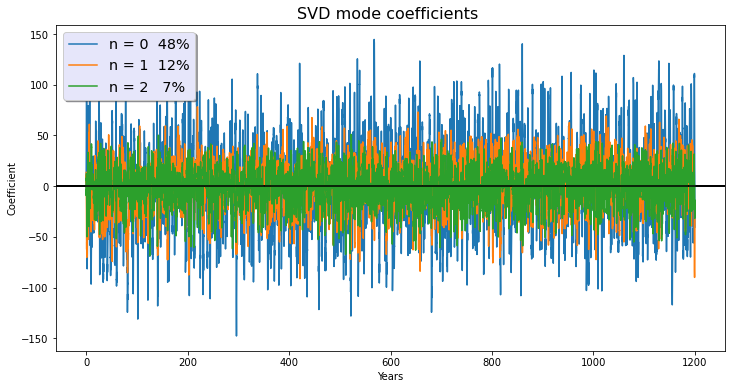

In [19]:
vars=sdatx**2/sum(sdatx**2)
years=np.arange(0,1200,1/12)
#years=np.arange(1958,2015,1/12)


bigtitle = 'SVD mode coefficients ' 
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(12,6))
index=0
ind_choice =[0,1,2]
for j in range(len(ind_choice)):
    ip=ind_choice[j]
    ax.plot(years, vdat_tot[ip,:],\
            label='n = '+str(ip) + '  {0:2.0f}%'.format(vars[ip]*100))
    ax.axhline(0.0, color='black')
ax.set_title(bigtitle,fontsize=16)
ax.set_xlabel('Years')
ax.set_ylabel('Coefficient')
#ax.set_ylim([0,0.006])
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('lavender')
#plt.savefig((bigtitle + ' '  ).replace(' ', '_').replace('.','_')+'.pdf' )
plt.show()

In [20]:
del(ds)

# Definition of functions

## Definition order_w

In [21]:
def order_w(w,option='magnitude',direction='up'):
    '''
    Order Eigenvalues according to 
    option
    'magnitude'         abs(w)
    'frequency'         w.imag
    'growth'            w.real
    'ones'              abs(w) closest to 1.0
    
    direction
    'up'               descending
    'down'             ascending
    
    '''
    print(' Ordering Eigenvalues as ', option, ' with direction ',direction)
    w_cont = np.log(w)
    if option == 'magnitude':
        ind=abs(w).argsort()
    elif option == 'frequency':
        ind=abs(w_cont.imag).argsort()
    elif option == 'growth':
        ind=np.abs(w_cont.real - 0.0).argsort()
    elif option == 'one':
        ind=np.abs(np.abs(w) - 1.0).argsort()
    else:
        print(' Error in oder_w', option, direction)
# Choose direction
    if direction == 'up':
        indu=ind[::-1]
    else:
        indu=ind

    w0=w[indu]
    w1=w_cont[indu]
    return w0,w1,indu


## Definition function evolve and verify

In [22]:
def evolve(tim_level,tstep,init_date):
    #tim_level=[0,1,2,3,4,5,6]
    #cases =  216,228,240, 36,48,60,  360,372,384
    #tstep=3
    #nstart=360
    x0=PsiX[:,init_date]
    ht=np.zeros([x0.shape[0],len(tim_level)],dtype='complex')
    for j in tim_level:
        D = np.diag(vw_s[:nmode]**(j*tstep))                  # w --> vw_s
        ht[:,j]=alpha@D@vcut.T@Gxx[init_date,:] 
    return ht

#verify to EOF expansion
def verify(tim_level,tstep,init_date,PCs,ht,verbose=False):
    sstcor=np.zeros([len(tim_level)])
    sstlab=np.zeros([len(tim_level)],dtype='int')
    for neig in range(len(tim_level)):
        kaz1=ht[:,neig].real 
        kaz2=PCs[:,int(init_date+neig*tstep)]
        ytmp = np.expand_dims(udat_tot[:,0:nEOF_SST]@kaz1, axis=1)
        ztmp = np.expand_dims(udat_tot[:,0:nEOF_SST]@kaz2, axis=1)
        #ICcase=lib.year2date(years,nstart)
        #ICdat=lib.year2date(years,tstep*neig+nstart)
        #label1 = ' at {}, IC at {}'.format(ICdat,ICcase)
        val=np.corrcoef(ytmp[:,0],ztmp[:,0])[0,1]
        if verbose : print(' Correlation at {}    {}'.format(label1,val))
        sstcor[neig]=val
        sstlab[neig]=int(tstep*neig+init_date)
    return sstcor,sstlab


#verify to total data
def verify_tot(tim_level,tstep,init_date,X,ht,verbose=False):
    sstcor=np.zeros([len(tim_level)])
    sstlab=np.zeros([len(tim_level)],dtype='int')
    for neig in range(len(tim_level)):
        kaz1=ht[:,neig].real 
        ytmp = np.expand_dims(udat_tot[:,0:nEOF_SST]@kaz1, axis=1)
        ztmp = X.A.data[:, int(init_date+neig*tstep)]
        #ICcase=lib.year2date(years,nstart)
        #ICdat=lib.year2date(years,tstep*neig+nstart)
        #label1 = ' at {}, IC at {}'.format(ICdat,ICcase)
        val=np.corrcoef(ytmp[:,0],ztmp)[0,1]
        if verbose : print(' Correlation at {}    {}'.format(label1,val))
        sstcor[neig]=val
        sstlab[neig]=int(tstep*neig+init_date)
    return sstcor,sstlab

## Definition dates2years

In [23]:
def date2year(years,init_year,date):
    """Transform index date ['Jan' '1989' ] in index i.
    
    Years are from np.arange(1960,2020, 1/12)
    """
    mon=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
    y=float(date[4:8])
    m=mon.index(str(date[0:3]))
    index = (y-init_year)*12 + m
    return int(index)

In [24]:
def year2date(years,i):
    """ Transform index i in string date yy/mm.
    
    Rounding requires the small shift
    Years are obtained from np.arange(1920,2018, 1/12)
    """
    mon=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
    y=str(int(years[i]+0.001))
    m=np.mod(int(round((years[i]-int(years[i]))*12)),12)
    date = mon[m] + ' ' + y
    return date

## Definition eigenvalues on points

In [25]:
def eigenfunction_value(cc, KK_tot, x, mode ):
    '''
    Compute eigenfunction value at point x

    Parameters
    ----------
    x: Point at which eigenfunction is computed
    mode: Mode number

    Returns
    -------
    eigenfunction value
    '''
    k = KK_tot.ker
    f = 0
    for i in range(KK_tot.ntime):
        f +=  cc[i,mode]*k(x, KK_tot.PsiX[:, i])       #somma per tutti i tempo: componente del modo (colonna) per kernel(initial condition x, fila PsiX)
    return f

## Definition sigma cost function

In [26]:
from scipy.optimize import minimize_scalar

In [27]:
def cost(x):
    ss = str(x)
    KK_tot.fit(bandwidth=ss)
    KMM = sc.pinv(KK_tot.vv)@(KK_tot.PsiX.T)
    return sum(lin.norm(KK_tot.vv@KMM-KK_tot.PsiX.T, axis=0))

# Select data

In [28]:
#Choose number of EOFs for each variable
nEOF_SST= 23
nEOF_D20= 0
nEOF_WS= 0

In [29]:
#insert nº of EOFs retained, limit of the training period, tau0 and number of lags
nEOF= nEOF_SST + nEOF_D20 + nEOF_WS     #23
tau0= 1                                 # tau=3 with 13/7/3 --> instabilities                         
leads= 10

In [30]:
# Select just X first EOFs
data_SST= vdat_tot[0:nEOF_SST,:]
#data_D20= vdat_totD20[0:nEOF_D20,:]
#data_WS= vdat_totWS[0:nEOF_WS,:]

In [31]:
#PCs = pd.concat([data_SST,data_D20, data_WS], axis=1)
#PCs=np.concatenate((data_SST,data_D20, data_WS), axis=0)
PCs=data_SST     #for an excatly identical result, needed to convert to float 64

In [32]:
PCs=PCs.astype('float64')
PCs.shape

(23, 14400)

# Creating cases

In [33]:
season_choice = 'JAN'
if season_choice == 'JAN':
    cases=['JAN '+str(i) for i in range(1970,2019)]
elif season_choice == 'FEB':
    cases=['FEB '+str(i) for i in range(1970,2019)]
elif season_choice == 'MAR':
    cases=['MAR '+str(i) for i in range(1970,2019)]
elif season_choice == 'APR':
    cases=['APR '+str(i) for i in range(1970,2019)]
elif season_choice == 'MAY':
    cases=['MAY '+str(i) for i in range(1970,2019)]
elif season_choice == 'JUN':
    cases=['JUN '+str(i) for i in range(1970,2019)]
elif season_choice == 'JUL':
    cases=['JUL '+str(i) for i in range(1970,2019)]
elif season_choice == 'AUG':
    cases=['AUG '+str(i) for i in range(1970,2019)]
elif season_choice == 'SEP':
    cases=['SEP '+str(i) for i in range(1970,2019)]
elif season_choice == 'OCT':
    cases=['OCT '+str(i) for i in range(1970,2019)]
elif season_choice == 'NOV':
    cases=['NOV '+str(i) for i in range(1970,2019)]
elif season_choice == 'DEC':
    cases=['DEC '+str(i) for i in range(1970,2019)]
    
tim_level=[0,1,2,3,4,5,6,7,8,9]
tstep=1

len_cases=len(cases)
totcor=np.zeros([len(tim_level),len_cases])
totlab=np.zeros([len(tim_level),len_cases])

In [34]:
tim_level=[0,1,2,3,4,5,6,7,8,9]
tim_level1=[1,2,3,4,5,6,7,8,9]
tim_level2=[2,3,4,5,6,7,8,9]

tstep=1
init_year=1950   #(instead of 1958)

In [35]:
tim_level=[0,1,2,3,4,5,6,7,8,9]
tim_level1=[1,2,3,4,5,6,7,8,9]
tim_level2=[2,3,4,5,6,7,8,9]

tstep=1
init_year=1950   #(instead of 1958)

# Modes computation (Coming from KOP-KMODES-UNIT)

In [36]:
%%time
options = {'operator': 'Koopman', 
            'kernel_choice': 'gauss',
           'bandwidth': 'std',
           'epsilon': 1e-5, 'time_data': X.A.time.data[:-1]}
if encode_svd:
    KK=Koop(vdat_tot,**options)
else:
    KK=Koop(xdat,**options)

Created Koopman Estimator 
 for 14399 samples and 360 features,             1 time interval
CPU times: user 146 µs, sys: 5 µs, total: 151 µs
Wall time: 155 µs


In [ ]:
KK.fit(bandwidth='std')

 Calculating Koopman Operator 
Using option std for a  6241.689277441486 and sigma 55.864520392828425



In [ ]:
condition=1e-15
bandwidth='std'

In [ ]:
condition = condition           #changed, 1e-15 for newer paper,     1e-5 older navarra paper

if KK.operator == 'Perron': 
    ops='P'
elif KK.operator =='Koopman':
    ops='K'
else:
    raise ValueError('TRANSFER_OP_GAUSS:  --- Wrong Operator choice ')
print(' Calculating {} Operator '.format(KK.operator))

KK.bandwidth = bandwidth

In [ ]:
if bandwidth is None or bandwidth == 'std':
    similarity=distance.squareform(distance.pdist(KK.PsiX.T ,'sqeuclidean'))
    scale=np.std(similarity.flatten())
elif bandwidth == 'median':
    similarity=distance.squareform(distance.pdist(KK.PsiX.T ,'sqeuclidean'))
    scale = np.median(similarity.flatten())
else:
    scale = 2*(float(bandwidth))**2

In [ ]:
KK.sigma = np.sqrt(scale/2)
print(f'Using option {bandwidth} for a  {scale} and sigma {KK.sigma}\n')

if KK.kernel_choice == 'gauss':
    k = kernels.gaussianKernel(KK.sigma)
elif KK.kernel_choice == 'poly':
    k = kernels.polynomialKernel(p=KK.poly_order,c=KK.poly_shift)
elif KK.kernel_choice == 'gaussShifted':
    k = kernels.gaussianKernelShifted(KK.sigma, shift=KK.k_shift)
else:
    raise ValueError(f'KK_fit:  --- WrongKernel choice {KK.kernel_choice}')

In [ ]:
X=KK.PsiX
Y=KK.PsiY
epsilon=KK.epsilon
evs=KK.maxeig
operator=ops
kind='kernel'

import klus.observables as _observables
import klus.kernels as _kernels
import numpy as _np
import scipy as _sp
import scipy.sparse.linalg

In [ ]:
if isinstance(X, list) or len(X.shape) < 2: # e.g., for strings
    n = len(X)
else:
    n = X.shape[1]
    
G_0 = _kernels.gramian(X, k)
G_1 = _kernels.gramian2(X, Y, k)

In [ ]:
if operator == 'K': G_1 = G_1.T   

In [ ]:
cond

In [ ]:
G_0.shape

In [ ]:
if kind =='kernel':
    A = _sp.linalg.pinv(G_0) @ G_1      #, rtol=cond  #rcond->sostituito con rtol          #G_0 + epsilon*_sp.eye(n)-->sostituito con G_0 
elif kind == 'embedded':
     A = G_1 @_sp.linalg.pinv(G_0, rtol=cond)    #rcond->sostituito con rtol          #G_0 + epsilon*_sp.eye(n)-->sostituito con G_0 
else:
    print("Error in KEDMD")

In [ ]:
def kedmd(X, Y, k, epsilon=0, evs=5, operator='P',kind='kernel',cond=1e-8):
    '''

    Returns
    -------
    A : ndarray
        Eigenfunction coefficients.
    d : ndarray 
        Eigenvalues.
    V : ndarray
        Eigenvectors.
    G_0 : ndarray
        Kernel matrix.
    G_1 : ndarray
        Kernel shifted data.
    '''

    if isinstance(X, list) or len(X.shape) < 2: # e.g., for strings
        n = len(X)
    else:
        n = X.shape[1]

    G_0 = _kernels.gramian(X, k)
    G_1 = _kernels.gramian2(X, Y, k)
    if operator == 'K': G_1 = G_1.T                   
    if kind =='kernel':
        A = _sp.linalg.pinv(G_0) @ G_1      #, rtol=cond  #rcond->sostituito con rtol          #G_0 + epsilon*_sp.eye(n)-->sostituito con G_0 
    elif kind == 'embedded':
         A = G_1 @_sp.linalg.pinv(G_0, rtol=cond)    #rcond->sostituito con rtol          #G_0 + epsilon*_sp.eye(n)-->sostituito con G_0 
    else:
        print("Error in KEDMD")
        
    d, V = sortEig(A, evs)
    if operator == 'K': 
        W = G_0 @ V
    else:
        W = V
       
    # Compute coefficients for eigenfunctions calculations
    if operator == 'K':
        C = V
    else:
        C = _sp.linalg.pinv(G_0, rtol=cond) @ V    #rcond->sostituito con rtol          #G_0 + epsilon*_sp.eye(n)-->sostituito con G_0 

    return d, W, C, A, G_0,G_1

In [ ]:
def fit(self,bandwidth=None, condition= 1e-15):               #taken from zapata vecchio
        ''' 
        Fitting estimator.
        Select bandwidth with `bandwidth`
        -------  
        ww:
            Eigenvalues
        self.wwg = np.log(ww_tot)/self.deltat:
            Generator Eigenvalues
        self.vv:
            Value of Eigenfunctions at samples
        self.Gxx:
            kernel matrix Gxx
        self.Gxy:
            kernel matrix Gxy
        self.ker:
            Kernel used

        '''
        condition = condition            #changed, 1e-15 for newer paper,     1e-5 older navarra paper

        
        if self.operator == 'Perron': 
            ops='P'
        elif self.operator =='Koopman':
            ops='K'
        else:
            raise ValueError('TRANSFER_OP_GAUSS:  --- Wrong Operator choice ')
        print(' Calculating {} Operator '.format(self.operator))

        self.bandwidth = bandwidth

        if bandwidth is None or bandwidth == 'std':
            similarity=distance.squareform(distance.pdist(self.PsiX.T ,'sqeuclidean'))
            scale=np.std(similarity.flatten())
        elif bandwidth == 'median':
            similarity=distance.squareform(distance.pdist(self.PsiX.T ,'sqeuclidean'))
            scale = np.median(similarity.flatten())
        else:
            scale = 2*(float(bandwidth))**2
       
        self.sigma = np.sqrt(scale/2)
        print(f'Using option {bandwidth} for a  {scale} and sigma {self.sigma}\n')

        if self.kernel_choice == 'gauss':
            k = kernels.gaussianKernel(self.sigma)
        elif self.kernel_choice == 'poly':
            k = kernels.polynomialKernel(p=self.poly_order,c=self.poly_shift)
        elif self.kernel_choice == 'gaussShifted':
            k = kernels.gaussianKernelShifted(self.sigma, shift=self.k_shift)
        else:
            raise ValueError(f'KK_fit:  --- WrongKernel choice {self.kernel_choice}')
        
        ww_tot,vv_tot,cc_eig,A,Gxx,Gxy =al.kedmd(self.PsiX,self.PsiY, k, \
                epsilon=self.epsilon, evs=self.maxeig, operator=ops,kind='kernel',cond=condition)
        
        print(f'Computed Transfer Eigenvalues')
        self.ww = ww_tot
        self.wwg = np.log(ww_tot)/self.deltat
        self.vv = vv_tot
        self.cc = cc_eig
        self.Gxx = Gxx
        self.Gxy = Gxy
        self.ker = k

        return 
    

In [ ]:
# Choose Damping Years
ty = 300
toleps = np.exp(1/(ty*12)) -1
tolyears = 1/np.log(1+toleps)/12
tolone = toleps
print(tolone,tolyears, toleps)

In [ ]:
wf,wfg,vvf = KK.order(cut_period=3)
wo,vvo,indone = KK.eigone(wf,vvf,tolone)
wo.shape,vvo.shape
ds = KK.compute_modes(wo,vvo,modetype='',description='')

In [ ]:
# Find quickly norms for plotting
vvnorm = sc.norm(KK.vv[:,indone],axis=0)

vmax = max(vvnorm)
vmin = min(vvnorm)
vscale = (vvnorm - vmin)/(vmax-vmin)

#plot of Koopman Eigenvalues
fig,axu = plt.subplots(1, 2,figsize=(12,6),constrained_layout=True)
plt.style.context('fivethirtyeight')

plimz=1.1
plim = 5
ar=50

ax = axu[0]
ax.scatter(KK.ww.real, KK.ww.imag, s=ar,alpha=0.5)
ax.axvline(0, color='black',lw=0.8)
ax.set_title(f' Total, $\epsilon$={KK.epsilon}',fontsize=16,loc='left')
ax.set_title(f'{data_name}',fontsize=16,loc='right')
ax.set_xlabel('Re',fontsize = 16)
ax.set_ylabel('Im',fontsize = 16)
ax.set_xlim(-plimz,plimz)
ax.set_ylim(-plimz,plimz)

ax = axu[1]
ax.scatter(wo.real, wo.imag, s=ar,alpha=vscale)
ax.axvline(0, color='black',lw=0.8)
ax.set_title(f' Total, $\epsilon$={KK.epsilon}',fontsize=16,loc='left')
ax.set_title(f'{data_name}',fontsize=16,loc='right')
ax.set_xlabel('Re',fontsize = 16)
ax.set_ylabel('Im',fontsize = 16)
ax.set_xlim(-plimz,plimz)
ax.set_ylim(-plimz,plimz)

zmap.changelabel(axu,fontsize=14,fontfamily='DejaVu Sans',fontweight='normal')
zmap.changebox(axu,'all',linewidth=2,color='black',capstyle='round')

plt.suptitle(f'Eigenvalues SST',fontsize=28)
plt.savefig(f'{data_name}{case}Eig4_{KK.sigma:.3f}_{KK.epsilon}{KK.kernel_choice}.pdf')        
plt.show()

In [ ]:
# # Create Xmat Matrix for Reconstructed state space
# X_recon = xr.full_like(X.A,0,dtype='float').isel(time=slice(0,len(X.A.time)-1))

# # If encoded on EOF go back to physical space
# if encode_svd:
#     X_recon.data = KK.reconstruct_koopman(ds,decode=udat)
# else:
#     X_recon.data = KK.reconstruct_koopman(ds,decode=None)

## Find koopman modes according to high variance

In [ ]:
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1))

from matplotlib.ticker import FormatStrFormatter

(v_o,KM_o,VM_o, vw_o),(indnorm, v_s,KM_s,VM_s,vw_s) = \
   KK.find_norm_modes(ds.kmodes, ds.keigfun, ds.eigval, sort='sort',decode=udat)
# v_s, KM_s, wto_s = zkop.find_norm_modes(KM_ordered,wto)

fig, axu = plt.subplots(1, 1, figsize=(12,6),constrained_layout=True)

locmaxvar = argrelextrema(v_s, np.greater)
xloc = np.arange(len(v_s))

axu.bar(np.arange(len(v_s)),v_s/max(v_s))
axu.set_title('Koopman Modes',{'fontsize' :24})
axu.set_title(f'Gaussian Kernel, NM={len(v_s)}, BW={KK.sigma:.2f}',loc='right')
axu.set_title(f'{data_name}',loc='left')
axu.set_ylabel('$||v_j||/max(||v||)$',fontsize=14)
axu.yaxis.set_major_formatter(formatter)
zmap.changelabel(axu,fontsize=14,fontfamily='Futura',fontweight='bold')
zmap.changebox(axu,'all',linewidth=1.5)
for i in  range(len(locmaxvar[0])):
    axu.text(xloc[locmaxvar[0][i]].squeeze()-0.25,v_s[locmaxvar[0][i]],f'{locmaxvar[0][i].squeeze():0.0f}')
xloc.shape,locmaxvar[0]
labfile =  f'{data_name}{case}_KMODE_Freq_{KK.sigma:.3f}_{KK.epsilon}_{KK.kernel_choice}{tolone}.pdf'
plt.savefig(labfile)
plt.show()

## Write to disk Koopman decomposition in geographical terms

In [ ]:
if write_files:
    labfile = f'dskd_{data_name}_{KK.sigma:.3f}_{KK.epsilon}{KK.kernel_choice}.nc'
else:
    labfile = None
dskm = zkop.expand_modes(v_o,KM_o,VM_o, vw_o,v_s,KM_s,VM_s,vw_s , X=X,file=labfile)

In [ ]:
bcut = 300
# bcut =1./np.log(1+tolone)/12
print(f'Cut in months for generator eigenvalue {bcut:.3f}, and tolerance {tolone}')
def loc_fig(v_o,vw_o,file):
    fig, axu = plt.subplots(1, 1, figsize=(12,6),constrained_layout=True)
    xp = np.arange(len(v_o))
    vloc = v_o/max(v_o)
    vwloc=np.log(vw_o).data

    for i in range(len(vloc)):
        wtest=(1./vwloc[i].real/12)
        if (wtest > -bcut) and (wtest < 0):  #Damped
            axu.bar(xp[i],vloc[i],alpha=0.8, color='navajowhite')
            # print(wtest,i,'Damp',vloc[i])
            ckaz=0
        elif wtest < bcut and wtest > 0:  #Growing
            axu.bar(xp[i],vloc[i],alpha=0.8, color='lightblue')
            # print(wtest,i,'Grow',vloc[i])
        else:  #Stable
            color='coral'
            # print(wtest,i,'Stable',vloc[i])
            axu.bar(xp[i],vloc[i], alpha=1.0,color='coral')
    axu.set_title('Koopman Modes',{'fontsize' :24})
    axu.set_title(f'Gaussian Kernel, NM={len(v_s)}, BW={KK.sigma:.2f}',loc='right')
    axu.set_title(f'{data_name}',loc='left')
    axu.set_ylabel('$||v_j||/max(||v||)$',fontsize=14)
    axu.set_xlabel('Period (Yr)',fontsize=14)
    axu.yaxis.set_major_formatter(formatter)
    zmap.changelabel(axu,fontsize=14,fontfamily='Futura',fontweight='bold')
    zmap.changebox(axu,'all',linewidth=1.5)
    if len(vw_o) > 10:
        xtickloc = np.arange(0,len(vw_o),int(len(vw_o)/10) )
    else:
        xtickloc = np.arange(0,len(vw_o))                    
    xticklab = [f'{zkop.one_over_years(vwloc.imag[i]):.3f}' for i in xtickloc]
    plt.xticks(xtickloc,xticklab)
 
    locmaxvar = argrelextrema(vloc, np.greater)
    for i in  range(len(locmaxvar[0])):
        axu.text(xloc[locmaxvar[0][i]].squeeze()-0.75,vloc[locmaxvar[0][i]]+0.01,\
                 f'{zkop.one_over_years(vwloc.imag[locmaxvar[0][i]]):0.2f}')
    
    

    legend_elements = [Line2D([0], [0], color='coral', lw=4, label='Stable'),
                      Line2D([0], [0], color='navajowhite', lw=4, label='Damped'),
                      Line2D([0], [0], color='lightblue', lw=4, label='Growing')]
    # axu.legend(handles=legend_elements, loc='upper left')
    with open('BARTR.pickle','wb') as filed:
        pickle.dump(axu, filed, pickle.HIGHEST_PROTOCOL)


    plt.savefig(file)
    plt.show()
labfile =  f'{data_name}{case}_KMODE_Freq_{KK.sigma:.3f}_{KK.epsilon}_{KK.kernel_choice}{tolone}.pdf'
loc_fig(v_o, vw_o,labfile)
# labfile =  f'{data_name}{case}_KMODE_LowFreq_{KK.sigma:.3f}_{KK.epsilon}_{KK.kernel_choice}{tolone}.pdf'
# loc_fig(v_o[0:80], vw_o[0:80],labfile)
locmaxvar